# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_portuguese')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0                   Como é ser a última pessoa na terra?   
1           Você pode explicar o conceito de Anarquismo?   
2      Qual é a melhor maneira de pendurar uma pintur...   
3      Qual é a relação entre o problema de controle ...   
4      Identifique qual instrumento é corda ou percus...   
...                                                  ...   
48566                 Qual é a história da luta de sumô.   
48567              Como posso melhorar falar em público.   
48568  Como faço para navegar até um determinado loca...   
48569  Quais são algumas dicas de etiqueta de mensage...   
48570  Estou pensando em participar de um concurso de...   

                                              completion  
0      Você pensaria que o mundo seria seu para explo...  
1      O anarquismo é uma filosofia política que defe...  
2      A melhor maneira de pendurar uma pintura com s...  
3      A noção de controle se manifesta quando contem...  
4                   Liuqin é corda, Nagareh é percussão.  
...                                                  ...  
48566  A luta de sumô é uma forma antiga de arte marc...  
48567  Comece estando preparado. Pesquise o tópico, p...  
48568  Para navegar até um determinado local usando t...  
48569  Apresente-se - Deixe a pessoa saber quem você ...  
48570  Eu recomendaria que você se concentrasse em su...  

[48571 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import GPT2Tokenizer

model = "pierreguillou/gpt2-small-portuguese" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "PT-124M" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48571
The longest demonstration is 324 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,713
Number of validation samples: 4,858


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=32 # 32, 20, 8, 4
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=32
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6 #6, 8, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  12
Number of transformer blocks to  un-freeze:  6
Number of frozen layers: 73
Number of trainable layers: 75


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 5 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 5



 29%|██▉       | 400/1367 [03:29<08:18,  1.94it/s]


Batch 400 of 1367. Loss:0.8450407981872559.


Example output: Como faço para manter um carro corretamente.Comece avaliando o carro como ele funciona no dia e avaliando sua durabilidade e estabilidade.
2. Se você possui um carro e deseja substituir o carro com um novo, você deve escolher o melhor ajuste, como usar um limpadores ou amortecedores ou um novo filtro elétrico.
3. Se você não for um bom carro, encontre maneiras de trocar de gasolina e reduzir o consumo de combustível, como usar um motor elétrico ou usar carros de baixo consumo.
4. Se você não deseja substituir o carro com um novo, encontre maneiras de trocar de óleo ou substituir a transmissão.



 59%|█████▊    | 800/1367 [06:58<04:52,  1.94it/s]


Batch 800 of 1367. Loss:0.9422707557678223.


Example output: Como posso meditar de forma eficaz.Uma maneira de meditar de forma eficaz é praticar técnicas de meditação guiada por atenção plena. Pratique respiração profunda e respiração profunda até atingir sua concentração no momento presente. Tente encontrar uma maneira de se concentrar em sua respiração, percebendo sua respiração e pensamentos, concentrando-se em perceber seus próprios estados mentais. Além disso, certifique-se de praticar técnicas de meditação de mantra para manter um equilíbrio de momento presente.



 88%|████████▊ | 1200/1367 [10:26<01:26,  1.94it/s]


Batch 1200 of 1367. Loss:0.9989928007125854.


Example output: Você pode fornecer uma definição para emulação de cérebro inteiro (WBE)?Eliezer Yudkowsky cunhou o termo "WBE" em 1996, argumentando que sistemas de IA são capazes de criar e analisar imagens cerebrais complexas.

Por sua vez, o conceito de Whole Brain Emulation (WBE) foi cunhado pelo neurocientista russo Vladimir S. Gozhanin em 1971, que se enquadra no grupo "Whole Brain Emulation: A Roadmap".

Nos anos recentes, a tecnologia moderna de inteligência artificial tem aumentado sua proficiência na resolução de problemas NP-completos, tornando-se cada vez mais uma força vital para tarefas relacionadas à visão computacional. Além disso, a robótica tem se tornando um recurso valioso no campo, contribuindo significativamente para a inteligência artificial moderna.



100%|██████████| 1367/1367 [11:54<00:00,  1.91it/s]



Average Training Loss: 0.9471002545074206.


Validation loss: 0.7749460453265592.


Beginning epoch 2 of 5



 29%|██▉       | 400/1367 [03:26<08:18,  1.94it/s]


Batch 400 of 1367. Loss:0.7124763131141663.


Example output: Que fatos interessantes você pode me contar sobre o presidente Abraham Lincoln?Lincoln, o 13º presidente dos Estados Unidos, foi um advogado que foi responsável por estabelecer a Lei de Escândalo do Bankingestado em 1903. Ele foi acusado de fornecer informações que poderiam ter sido usadas para fazer uma série de negócios fraudulentos.



 59%|█████▊    | 800/1367 [06:53<04:52,  1.94it/s]


Batch 800 of 1367. Loss:0.6731818318367004.


Example output: O motor do meu carro começou a fazer um barulho estranho. O que poderia estar causando isso.A primeira etapa é verificar a pressão do ar na roda. Certifique-se de que está funcionando corretamente. Verifique se há vazamentos de óleo, pneus, freios ou outros problemas. Se estiver de funcionar, substitua o motor quanto à quilometragem da roda. Se a aceleração for muito alta, verifique o painel do acelerador para garantir que esteja funcionando corretamente e certifique-se de que o bujão de freio esteja funcionando corretamente.



 88%|████████▊ | 1200/1367 [10:20<01:26,  1.94it/s]


Batch 1200 of 1367. Loss:0.6759688258171082.


Example output: Você pode me falar sobre os benefícios para a saúde das maçãs.As maçãs têm uma grande variedade de vitaminas, minerais e outros nutrientes benéficos. Estudos demonstraram que as maçãs podem ajudar a melhorar a saúde, como reduzir a inflamação, ajudar a melhorar a saúde digestiva e estimular a criatividade. Comer maçãs pode ajudar a reduzir o risco de doenças cardíacas e algumas doenças cardíacas crônicas, como câncer e diabetes. Também pode ajudar a diminuir o risco de certos tipos de câncer e melhorar o desempenho geral. As maçãs também são baixas em calorias e gorduras não saudáveis, o que é importante para uma dieta saudável e equilibrada. Além disso, as maçãs são uma excelente fonte de fibra e pode ajudar na digestão, que é vital para ajudar a manter uma boa saúde geral.



100%|██████████| 1367/1367 [11:48<00:00,  1.93it/s]



Average Training Loss: 0.7373575027963936.


Validation loss: 0.7309620019636656.


Beginning epoch 3 of 5



 29%|██▉       | 400/1367 [03:26<08:18,  1.94it/s]


Batch 400 of 1367. Loss:0.6310281753540039.


Example output: Quero começar a escrever um blog, mas estou tendo problemas para ter ideias. Você pode sugerir alguns temas.Proposta: O primeiro passo é criar um título que resuma seus pontos principais. Você deve começar apresentando conteúdo sobre como ele funciona e como ele funciona com um leitor.

2 Depois que seu título seja lançado, comece a escrever links para ele. Certifique-se de incluir palavras-chave relevantes para seus leitores e mantenha seus leitores voltando.

3 Depois disso, crie uma lista de tópicos do seu blog que deseja explorar e acompanhar seus leitores por alguns dias. Certifique-se de dar atenção a quaisquer tendências, opiniões e análises de blogs que possam mudar suas postagens.

4 Por fim, considere escrever um breve resumo das principais seções do seu blog para ajudá-lo a identificar as áreas que você recomendaria para leitores mais novos.

5 Em última análise, cada tópico é um bom cenário para começar sua nova

 59%|█████▊    | 800/1367 [06:55<04:51,  1.94it/s]


Batch 800 of 1367. Loss:0.681230366230011.


Example output: Quais oportunidades de trabalho estão disponíveis para alguém com graduação em química.Existem muitos cursos disponíveis para pessoas com graduação em química. A Harvard University e o University of Pennsylvania oferecem serviços com experiência em química. O Stanford College of Medicine oferece aulas de bacharel em química e doutorado em química. O Brigham and Women's College of Science, Massachusetts Institute of Technology, Dartmouth College of Medicine e Harvard Medical School são dois dos dois centros médicos.



 88%|████████▊ | 1200/1367 [10:22<01:26,  1.94it/s]


Batch 1200 of 1367. Loss:0.6577063202857971.


Example output: Qual é o objetivo da regulamentação geral de privacidade e proteção de dados (GDPR)?No âmbito da ética da IA, o princípio da privacidade encapsula um domínio fundamental de propriedade parcial e controle sobre a exposição de informações pessoais a uma rede. Com uma compreensão desta técnica impactada, torna-se imperativo desenvolver medidas proativas para salvaguardar o bem-estar das pessoas e sistemas de IA.



100%|██████████| 1367/1367 [11:49<00:00,  1.93it/s]



Average Training Loss: 0.6574105381878432.


Validation loss: 0.7102324895952877.


Beginning epoch 4 of 5



 29%|██▉       | 400/1367 [03:26<08:18,  1.94it/s]


Batch 400 of 1367. Loss:0.5170938372612.


Example output: Qual é a melhor maneira de aumentar os níveis de energia pela manhã.A melhor maneira de aumentar os níveis de energia pela manhã é fazer atividades que você goste, como caminhar ou correr, ler um livro, meditar ou meditar, ouvir uma música relaxante, praticar atividade física regular, comer uma dieta balanceada e fazer uma pausa em determinados momentos da semana para relaxar e recarregar.



 59%|█████▊    | 800/1367 [06:53<04:52,  1.94it/s]


Batch 800 of 1367. Loss:0.6901150941848755.


Example output: Quais escolas de ética surgiram na tradição ocidental e o que elas implicam?A Filosofia Moral, que é uma divisão da Filosofia, concentra-se nos princípios que nos conduzem ao desenvolvimento e na tomada de decisões éticas. Abrange o exame díspares das convicções éticas encontradas nos indivíduos, abrangendo a deontologia, a ética das virtudes, a ética da virtude e a ética da virtude.



 88%|████████▊ | 1200/1367 [10:20<01:26,  1.94it/s]


Batch 1200 of 1367. Loss:0.4600249230861664.


Example output: Forneça conselhos sobre como atingir minhas metas de condicionamento físico.A melhor maneira de atingir seus objetivos de condicionamento físico é praticar. Comece definindo metas alcançáveis e mensuráveis e divida-as em etapas alcançáveis e alcançáveis. Acompanhe seu progresso, depois use esses resultados para desenvolver um plano de estudo e use-o para garantir que você fique em forma. Você também pode tentar incorporar exercícios de baixo impacto ou atividades com uma força positiva, como caminhar, correr ou ouvir música. Depois de atingir essas metas, você pode investir em atividades de maior intensidade, como treinamento de força, treinamento de flexibilidade, e treinamento intervalado. Por fim, recompense-se por cumprir o trabalho árduo e atingir seus objetivos de condicionamento físico.



100%|██████████| 1367/1367 [11:48<00:00,  1.93it/s]



Average Training Loss: 0.5974375438040508.


Validation loss: 0.7050648294389248.


Beginning epoch 5 of 5



 29%|██▉       | 400/1367 [03:26<08:18,  1.94it/s]


Batch 400 of 1367. Loss:0.6328504681587219.


Example output: Qual é o papel da entropia cruzada no aprendizado de máquina?A entropia cruzada mede a dissimilaridade entre duas distribuições de probabilidade. É uma ferramenta indispensável no campo da avaliação de distribuições de probabilidade e mede a divergência entre duas distribuições de probabilidade.



 59%|█████▊    | 800/1367 [06:53<04:52,  1.94it/s]


Batch 800 of 1367. Loss:0.5364123582839966.


Example output: O que significa aprendizagem federada?FL é um método em aprendizado de máquina que treina modelos usando exemplos descentralizados em dispositivos como smartphones para aprender uma nova habilidade. Nessa abordagem, um servidor central distribui o modelo atual ao servidor, que a treina em uma versão de coordenação (C) e armazenada na rede. A rede é então usada para fazer melhorias no modelo, o que pode levar a melhorias na qualidade do modelo geral ou até mesmo gerar um modelo global mais personalizado.



 88%|████████▊ | 1200/1367 [10:20<01:26,  1.94it/s]


Batch 1200 of 1367. Loss:0.5115535855293274.


Example output: Quero começar a me exercitar, mas não sei como. Você pode me fornecer um plano de exercícios para iniciantes.Eu recomendo começar com exercícios básicos de peso corporal, como flexões, flexões e agachamentos. Esses exercícios podem ajudá-lo a construir força, reduzir a tensão muscular e queimar calorias rapidamente. Existem muitos livros e vídeos online que fornecem exercícios para iniciantes. Esses exercícios podem ajudá-lo a desenvolver e manter uma boa saúde cardiovascular e mental.



100%|██████████| 1367/1367 [11:47<00:00,  1.93it/s]



Average Training Loss: 0.551684551763988.


Validation loss: 0.7048302759465418.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-PT-124M/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-PT-124M/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-PT-124M/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-PT-124M/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-PT-124M/added_tokens.json')

13. Check the training stats and plot the learning curves.

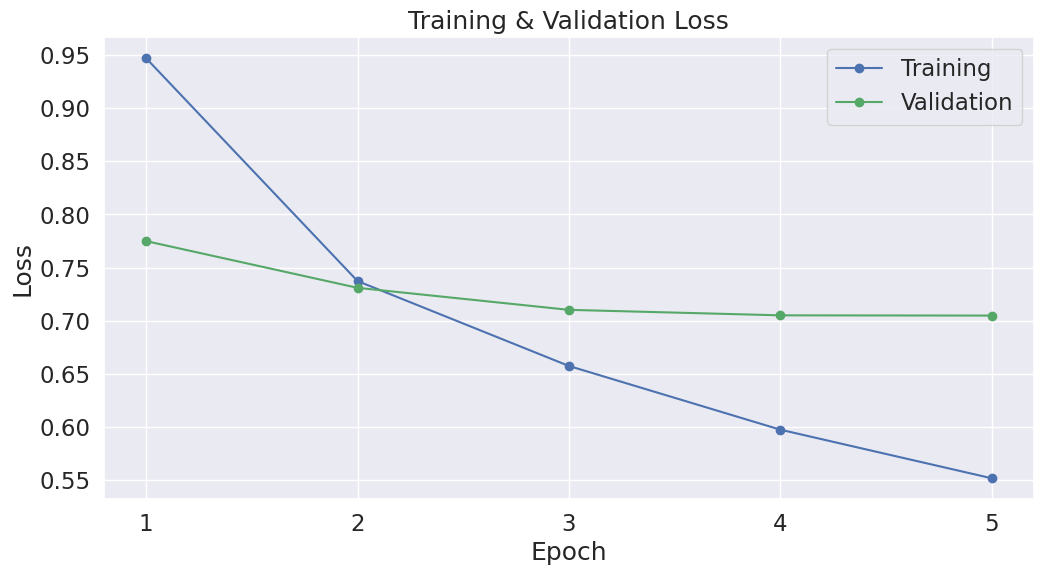

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Question: 👤 Como eu posso aprender a programar?

Response 1: 🤖 Uma das melhores maneiras de aprender a programar é começar familiarizando-se com os fundamentos, como codificação, programação e análise de dados. Depois de dominar os fundamentos, você pode começar a praticar a programar em um campo específico, como ciência de dados, robótica ou inteligência artificial. Depois de ter uma boa compreensão dos conceitos básicos, você pode começar a praticar a codificação em um pequeno conjunto de desafios, como codificar um site básico, criar um aplicativo e começar a desenvolver aplicativos móveis.
Response 2: 🤖 A programar é uma habilidade que você pode aprender com uma variedade de materiais, como livros, tutoriais online, cursos e cursos. Em seguida, você pode praticar em um centro de tutoria ou em uma aula de certificação. Isso lhe dará uma compreensão mais profunda do processo de criação de programas de software.


Done! 🤗